# Install and import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from seqeval.metrics import f1_score, accuracy_score

2023-06-30 14:43:38.048702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 14:43:38.569742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

#test it
print(info[0]['annotations'])
print(info[0]['text'])
print(info[0]['annotations'][0]['start_offset'])

[{'label': 6, 'start_offset': 17, 'end_offset': 28, 'user': 1, 'created_at': '2023-06-14T14:36:46.643706Z', 'updated_at': '2023-06-14T14:36:46.643737Z'}, {'label': 2, 'start_offset': 89, 'end_offset': 91, 'user': 1, 'created_at': '2023-06-14T14:37:01.615695Z', 'updated_at': '2023-06-26T13:46:16.108486Z'}, {'label': 6, 'start_offset': 247, 'end_offset': 258, 'user': 1, 'created_at': '2023-06-14T14:37:39.635439Z', 'updated_at': '2023-06-14T14:37:39.635488Z'}, {'label': 3, 'start_offset': 461, 'end_offset': 475, 'user': 1, 'created_at': '2023-06-14T14:38:01.779370Z', 'updated_at': '2023-06-14T14:38:01.779403Z'}, {'label': 1, 'start_offset': 477, 'end_offset': 481, 'user': 1, 'created_at': '2023-06-14T14:38:12.949077Z', 'updated_at': '2023-06-26T14:45:46.411185Z'}, {'label': 2, 'start_offset': 498, 'end_offset': 500, 'user': 1, 'created_at': '2023-06-14T14:39:21.688854Z', 'updated_at': '2023-06-26T13:46:09.687470Z'}, {'label': 6, 'start_offset': 540, 'end_offset': 551, 'user': 1, 'created_

In [4]:
def labeler(sent, text, annotations):
    #sent will be the already parsed sentence, with everything removed
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    #monitor where in the text we are
    text_index = 0
    
    #monitor which word we are in
    sent_index = 0
    
    #keep track of which annotation label we are applying
    annotation_index = 0
    
    #will return all labels for each words
    labels = []
  
    while text_index < len(text) and sent_index < len(sent):
        if annotation_index >= len(annotations):
            for i in range(len(labels)-1, len(sent)):
                labels.append(data_tags[0])
                return labels
        
        #check if we are at the correct index
        if text[text_index]== sent[sent_index][0]:
            
            #double check
            if len(sent[sent_index])==1 or text[text_index+1]== sent[sent_index][1]:
                
                #if not true and the current label aplies to text behind the index behind current, adjest label that you are looking at
                if text_index > annotations[annotation_index]['end_offset']:
                    annotation_index +=1
                    
                else:
            
                    #check if the current text label falls in a label range.
                    #if true, apply correct label and move text_index and sent_index
                    if text_index >= annotations[annotation_index]['start_offset'] and text_index <= annotations[annotation_index]['end_offset']:
                        labels.append(data_tags[2*(annotations[annotation_index]['label'])-1])
                    
                    #if no label applies, apply '0' tag
                    else:
                        labels.append(data_tags[0])
                    
                    #adjust which word you are looking at and text_index
                    text_index += len(sent[sent_index])
                    sent_index += 1
                    
                
            else:
                text_index+=1
        else:
            text_index+=1
            
            
    return labels
        
        



In [5]:
import re
sentences = [re.findall(r"[\w']+", info[i]['text']) for i in range(len(info))]

#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

labels=[]

for i in range(len(sentences)):
    labels.append(labeler(sentences[i], info[i]['text'], info[i]['annotations'] ))

for i in range(len(labels)):
    for j in range(len(labels[i])):
        print(labels[i][j], sentences[i][j])
    print()


0 The
0 influence
0 of
R γ
R radiation
0 on
0 the
0 physical
0 characteristics
0 and
0 sorption
0 properties
0 for
M Am
0 of
0 the
0 solid
0 extractant
0 AXIONIT
0 MND
0 40T
0 TVEX
0 synthesized
0 by
0 Axion
0 Rare
0 and
0 Noble
0 Metals
0 JSC
0 Perm
0 was
0 studied
0 With
0 an
0 increase
0 of
0 the
0 absorbed
0 dose
0 of
R γ
R radiation
0 the
0 granulometric
0 composition
0 bulk
0 density
0 and
0 specific
0 volume
0 of
0 TVEX
0 change
0 insignificantly
0 The
0 IR
0 spectra
0 of
0 TVEX
0 demonstrate
0 significant
0 radiation
0 degradation
0 at
0 an
0 absorbed
0 radiation
0 dose
0 from
Q 1
Q 4
Q to
Q 2
Q 5
Q MGy
C TVEX
0 is
0 an
0 effective
M Am
0 sorbent
0 when
0 irradiated
0 to
0 an
0 absorbed
R γ
R radiation
0 dose
0 of
0 no
0 more
0 than
Q 0
Q 6
Q MGy
0 At
0 an
0 irradiation
0 dose
0 of
Q 2
Q 5
Q MGy
0 sorption

0 Basic
0 physicochemical
0 properties
0 of
0 the
C TVEX
0 sample
0 used
0 in
0 the
0 work
0 are
0 given
0 in
0 Table
0 1
C TVEX
0 was
0 synthesized
0 by
0 copolymerization


In [6]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [7]:
print(sentences[0],"\n",labels[0], "\n")

['The', 'influence', 'of', 'γ', 'radiation', 'on', 'the', 'physical', 'characteristics', 'and', 'sorption', 'properties', 'for', 'Am', 'of', 'the', 'solid', 'extractant', 'AXIONIT', 'MND', '40T', 'TVEX', 'synthesized', 'by', 'Axion', 'Rare', 'and', 'Noble', 'Metals', 'JSC', 'Perm', 'was', 'studied', 'With', 'an', 'increase', 'of', 'the', 'absorbed', 'dose', 'of', 'γ', 'radiation', 'the', 'granulometric', 'composition', 'bulk', 'density', 'and', 'specific', 'volume', 'of', 'TVEX', 'change', 'insignificantly', 'The', 'IR', 'spectra', 'of', 'TVEX', 'demonstrate', 'significant', 'radiation', 'degradation', 'at', 'an', 'absorbed', 'radiation', 'dose', 'from', '1', '4', 'to', '2', '5', 'MGy', 'TVEX', 'is', 'an', 'effective', 'Am', 'sorbent', 'when', 'irradiated', 'to', 'an', 'absorbed', 'γ', 'radiation', 'dose', 'of', 'no', 'more', 'than', '0', '6', 'MGy', 'At', 'an', 'irradiation', 'dose', 'of', '2', '5', 'MGy', 'sorption', 'capacity', 'is', 'significantly', 'reduced'] 
 ['0', '0', '0', 'R'

In [8]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased', do_lower_case=False)


In [9]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [10]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [11]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 64 # 64 or 128 or ...
bs = 5 # batch size


In [12]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [13]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [14]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [15]:
# Load BERT Model

model = BertForTokenClassification.from_pretrained(
    "allenai/scibert_scivocab_uncased",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

In [16]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [17]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 1e-5, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
epochs = 50

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# **Training**

In [19]:
def acc():
    accuracy_list = []
    
    for i in range(len(sentences)):

        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-2]
        accuracy_list.append(accuracy_score(new_labels, labels[i]))

        #print("\nPredict labels: ",new_labels)
        #print("Actual labels: ",labels[i])

        return statistics.mean(accuracy_list)



In [20]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

for e in trange(epochs, desc="Epoch"):
    
    max_test = 0
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = acc()
    test_acc.append(a)
    if a >= max_test:
        max = a
        torch.save(model, "test.ck")
    

Epoch:   0%|                                                                                                  | 0/50 [00:00<?, ?it/s]


Average train loss: 1.6911197900772095

Validation loss: 1.1932090520858765
Validation Accuracy: 0.7492401215805471



Epoch:   2%|█▊                                                                                        | 1/50 [00:05<04:29,  5.49s/it]


Average train loss: 0.9467549473047256

Validation loss: 0.6975653767585754
Validation Accuracy: 0.7750759878419453



Epoch:   4%|███▌                                                                                      | 2/50 [00:10<04:07,  5.16s/it]


Average train loss: 0.5690222159028053

Validation loss: 0.4271857738494873
Validation Accuracy: 0.8465045592705167



Epoch:   6%|█████▍                                                                                    | 3/50 [00:15<03:56,  5.03s/it]


Average train loss: 0.3937398958951235

Validation loss: 0.313605676094691
Validation Accuracy: 0.8677811550151976



Epoch:   8%|███████▏                                                                                  | 4/50 [00:20<03:50,  5.01s/it]


Average train loss: 0.29479860203961533

Validation loss: 0.2701905568440755
Validation Accuracy: 0.8890577507598785



Epoch:  10%|█████████                                                                                 | 5/50 [00:25<03:44,  4.98s/it]


Average train loss: 0.2313580447807908

Validation loss: 0.2279418408870697
Validation Accuracy: 0.9072948328267477



Epoch:  12%|██████████▊                                                                               | 6/50 [00:30<03:39,  5.00s/it]


Average train loss: 0.19554853237544498

Validation loss: 0.20385725796222687
Validation Accuracy: 0.9285714285714286



Epoch:  14%|████████████▌                                                                             | 7/50 [00:35<03:33,  4.97s/it]


Average train loss: 0.14872093809147677

Validation loss: 0.1971819500128428
Validation Accuracy: 0.9270516717325228



Epoch:  16%|██████████████▍                                                                           | 8/50 [00:40<03:28,  4.96s/it]


Average train loss: 0.10512104451966782

Validation loss: 0.19855472445487976
Validation Accuracy: 0.925531914893617



Epoch:  18%|████████████████▏                                                                         | 9/50 [00:45<03:23,  4.97s/it]


Average train loss: 0.0898564124169449

Validation loss: 0.22400087118148804
Validation Accuracy: 0.9164133738601824



Epoch:  20%|█████████████████▊                                                                       | 10/50 [00:50<03:18,  4.97s/it]


Average train loss: 0.07103173337721576

Validation loss: 0.2244767795006434
Validation Accuracy: 0.9209726443768997



Epoch:  22%|███████████████████▌                                                                     | 11/50 [00:54<03:12,  4.94s/it]


Average train loss: 0.06777602162522574

Validation loss: 0.2083133707443873
Validation Accuracy: 0.925531914893617



Epoch:  24%|█████████████████████▎                                                                   | 12/50 [00:59<03:08,  4.95s/it]


Average train loss: 0.04656172303172449

Validation loss: 0.2070128470659256
Validation Accuracy: 0.9285714285714286



Epoch:  26%|███████████████████████▏                                                                 | 13/50 [01:04<03:02,  4.94s/it]


Average train loss: 0.03928302230391031

Validation loss: 0.2387951761484146
Validation Accuracy: 0.9270516717325228



Epoch:  28%|████████████████████████▉                                                                | 14/50 [01:09<02:59,  4.98s/it]


Average train loss: 0.03369595065790539

Validation loss: 0.2263151854276657
Validation Accuracy: 0.9300911854103343



Epoch:  30%|██████████████████████████▋                                                              | 15/50 [01:14<02:53,  4.97s/it]


Average train loss: 0.031601320719346404

Validation loss: 0.23744928340117136
Validation Accuracy: 0.9270516717325228



Epoch:  32%|████████████████████████████▍                                                            | 16/50 [01:19<02:48,  4.96s/it]


Average train loss: 0.028635336241374414

Validation loss: 0.24156042436758676
Validation Accuracy: 0.9300911854103343



Epoch:  34%|██████████████████████████████▎                                                          | 17/50 [01:24<02:43,  4.96s/it]


Average train loss: 0.02118396353519832

Validation loss: 0.23111999531586966
Validation Accuracy: 0.9300911854103343



Epoch:  36%|████████████████████████████████                                                         | 18/50 [01:29<02:39,  4.98s/it]


Average train loss: 0.015802272382037092

Validation loss: 0.2458729644616445
Validation Accuracy: 0.9224924012158054



Epoch:  38%|█████████████████████████████████▊                                                       | 19/50 [01:34<02:34,  4.98s/it]


Average train loss: 0.016896895491906132

Validation loss: 0.2489235152800878
Validation Accuracy: 0.9285714285714286



Epoch:  40%|███████████████████████████████████▌                                                     | 20/50 [01:39<02:31,  5.03s/it]


Average train loss: 0.015570031391689554

Validation loss: 0.25050681829452515
Validation Accuracy: 0.9331306990881459



Epoch:  42%|█████████████████████████████████████▍                                                   | 21/50 [01:45<02:27,  5.10s/it]


Average train loss: 0.013286436539298544

Validation loss: 0.2406055231889089
Validation Accuracy: 0.9346504559270516



Epoch:  44%|███████████████████████████████████████▏                                                 | 22/50 [01:50<02:23,  5.12s/it]


Average train loss: 0.010228204919258133

Validation loss: 0.244150310754776
Validation Accuracy: 0.9331306990881459



Epoch:  46%|████████████████████████████████████████▉                                                | 23/50 [01:56<02:23,  5.31s/it]


Average train loss: 0.013273902489648512

Validation loss: 0.22152477006117502
Validation Accuracy: 0.939209726443769



Epoch:  48%|██████████████████████████████████████████▋                                              | 24/50 [02:01<02:17,  5.31s/it]


Average train loss: 0.008985131333853738

Validation loss: 0.2317708134651184
Validation Accuracy: 0.939209726443769



Epoch:  50%|████████████████████████████████████████████▌                                            | 25/50 [02:06<02:12,  5.32s/it]


Average train loss: 0.004591178051972141

Validation loss: 0.2432829091946284
Validation Accuracy: 0.939209726443769



Epoch:  52%|██████████████████████████████████████████████▎                                          | 26/50 [02:11<02:06,  5.28s/it]


Average train loss: 0.007377883230219595

Validation loss: 0.2605329056580861
Validation Accuracy: 0.9422492401215805



Epoch:  54%|████████████████████████████████████████████████                                         | 27/50 [02:17<02:01,  5.27s/it]


Average train loss: 0.00626545576233184

Validation loss: 0.2570769290129344
Validation Accuracy: 0.939209726443769



Epoch:  56%|█████████████████████████████████████████████████▊                                       | 28/50 [02:22<01:56,  5.27s/it]


Average train loss: 0.009326663430935392

Validation loss: 0.2592340757449468
Validation Accuracy: 0.9376899696048632



Epoch:  58%|███████████████████████████████████████████████████▌                                     | 29/50 [02:27<01:51,  5.29s/it]


Average train loss: 0.008055764442057503

Validation loss: 0.2734738488992055
Validation Accuracy: 0.939209726443769



Epoch:  60%|█████████████████████████████████████████████████████▍                                   | 30/50 [02:32<01:45,  5.27s/it]


Average train loss: 0.0033817675042276583

Validation loss: 0.26081354916095734
Validation Accuracy: 0.9407294832826748



Epoch:  62%|███████████████████████████████████████████████████████▏                                 | 31/50 [02:38<01:40,  5.27s/it]


Average train loss: 0.004563071563704095

Validation loss: 0.2715471734603246
Validation Accuracy: 0.939209726443769



Epoch:  64%|████████████████████████████████████████████████████████▉                                | 32/50 [02:43<01:34,  5.27s/it]


Average train loss: 0.00930405104008969

Validation loss: 0.26882221798102063
Validation Accuracy: 0.9407294832826748



Epoch:  66%|██████████████████████████████████████████████████████████▋                              | 33/50 [02:48<01:29,  5.25s/it]


Average train loss: 0.002759584157805269

Validation loss: 0.26903319855531055
Validation Accuracy: 0.939209726443769



Epoch:  68%|████████████████████████████████████████████████████████████▌                            | 34/50 [02:53<01:23,  5.25s/it]


Average train loss: 0.003534283307089936

Validation loss: 0.27543965478738147
Validation Accuracy: 0.939209726443769



Epoch:  70%|██████████████████████████████████████████████████████████████▎                          | 35/50 [02:59<01:18,  5.24s/it]


Average train loss: 0.005018846827927821

Validation loss: 0.27517248193422955
Validation Accuracy: 0.939209726443769



Epoch:  72%|████████████████████████████████████████████████████████████████                         | 36/50 [03:04<01:12,  5.19s/it]


Average train loss: 0.0022782652692209617

Validation loss: 0.27790344258149463
Validation Accuracy: 0.9407294832826748



Epoch:  74%|█████████████████████████████████████████████████████████████████▊                       | 37/50 [03:09<01:06,  5.10s/it]


Average train loss: 0.0030155735003063455

Validation loss: 0.28080249826113385
Validation Accuracy: 0.9376899696048632



Epoch:  76%|███████████████████████████████████████████████████████████████████▋                     | 38/50 [03:14<01:00,  5.06s/it]


Average train loss: 0.002270446636733444

Validation loss: 0.27959396441777545
Validation Accuracy: 0.9376899696048632



Epoch:  78%|█████████████████████████████████████████████████████████████████████▍                   | 39/50 [03:19<00:55,  5.07s/it]


Average train loss: 0.0017269107290000345

Validation loss: 0.27954601248105365
Validation Accuracy: 0.939209726443769



Epoch:  80%|███████████████████████████████████████████████████████████████████████▏                 | 40/50 [03:24<00:50,  5.09s/it]


Average train loss: 0.002707668643173141

Validation loss: 0.2844308167695999
Validation Accuracy: 0.939209726443769



Epoch:  82%|████████████████████████████████████████████████████████████████████████▉                | 41/50 [03:29<00:46,  5.14s/it]


Average train loss: 0.004074734497407917

Validation loss: 0.28623872498671216
Validation Accuracy: 0.9376899696048632



Epoch:  84%|██████████████████████████████████████████████████████████████████████████▊              | 42/50 [03:34<00:41,  5.17s/it]


Average train loss: 0.001954666785119722

Validation loss: 0.2877512375513713
Validation Accuracy: 0.939209726443769



Epoch:  86%|████████████████████████████████████████████████████████████████████████████▌            | 43/50 [03:40<00:36,  5.19s/it]


Average train loss: 0.0016496183889103122

Validation loss: 0.28809016942977905
Validation Accuracy: 0.939209726443769



Epoch:  88%|██████████████████████████████████████████████████████████████████████████████▎          | 44/50 [03:45<00:31,  5.22s/it]


Average train loss: 0.0015816949113893013

Validation loss: 0.2885914792617162
Validation Accuracy: 0.9376899696048632



Epoch:  90%|████████████████████████████████████████████████████████████████████████████████         | 45/50 [03:50<00:26,  5.23s/it]


Average train loss: 0.0020396578838699497

Validation loss: 0.28597265978654224
Validation Accuracy: 0.939209726443769



Epoch:  92%|█████████████████████████████████████████████████████████████████████████████████▉       | 46/50 [03:56<00:21,  5.35s/it]


Average train loss: 0.001821461904910393

Validation loss: 0.28623680273691815
Validation Accuracy: 0.9376899696048632



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████▋     | 47/50 [04:01<00:15,  5.33s/it]


Average train loss: 0.0014899131371445644

Validation loss: 0.2851891169945399
Validation Accuracy: 0.939209726443769



Epoch:  96%|█████████████████████████████████████████████████████████████████████████████████████▍   | 48/50 [04:06<00:10,  5.34s/it]


Average train loss: 0.0015790196557645686

Validation loss: 0.28476756314436596
Validation Accuracy: 0.939209726443769



Epoch:  98%|███████████████████████████████████████████████████████████████████████████████████████▏ | 49/50 [04:12<00:05,  5.31s/it]


Average train loss: 0.0029800142462287718

Validation loss: 0.2851942429939906
Validation Accuracy: 0.939209726443769



Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:17<00:00,  5.15s/it]


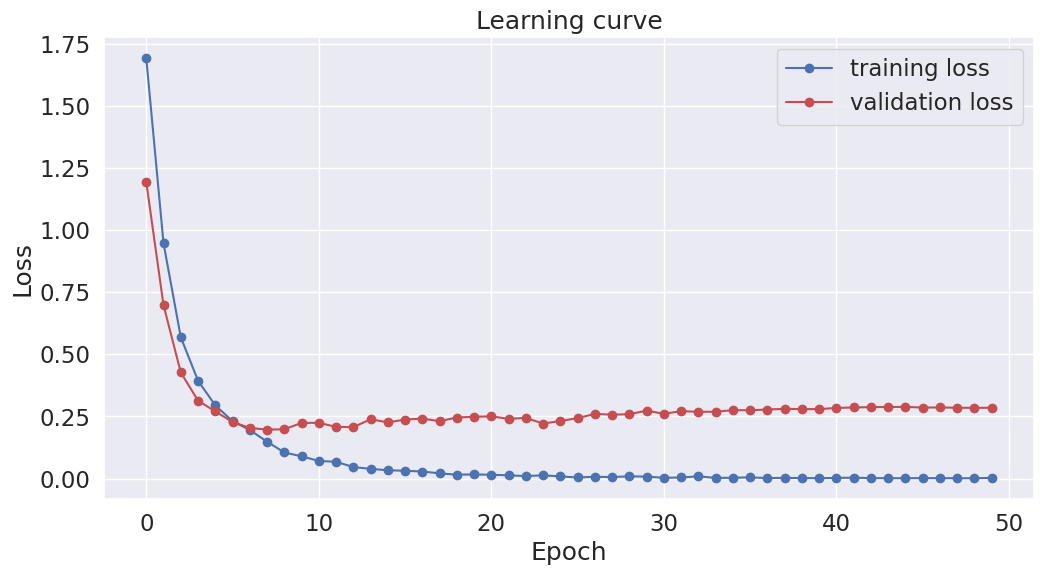

In [21]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [22]:
print(acc())

0.7614678899082569


In [23]:
print(test_acc)

[0.8440366972477065, 0.8165137614678899, 0.8073394495412844, 0.7981651376146789, 0.7981651376146789, 0.7798165137614679, 0.7706422018348624, 0.7706422018348624, 0.7706422018348624, 0.7798165137614679, 0.7798165137614679, 0.7706422018348624, 0.7522935779816514, 0.7706422018348624, 0.7522935779816514, 0.7614678899082569, 0.7706422018348624, 0.7706422018348624, 0.7706422018348624, 0.7798165137614679, 0.7431192660550459, 0.7339449541284404, 0.7706422018348624, 0.6880733944954128, 0.7431192660550459, 0.7522935779816514, 0.7431192660550459, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7431192660550459, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7522935779816514, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569, 0.7614678899082569]

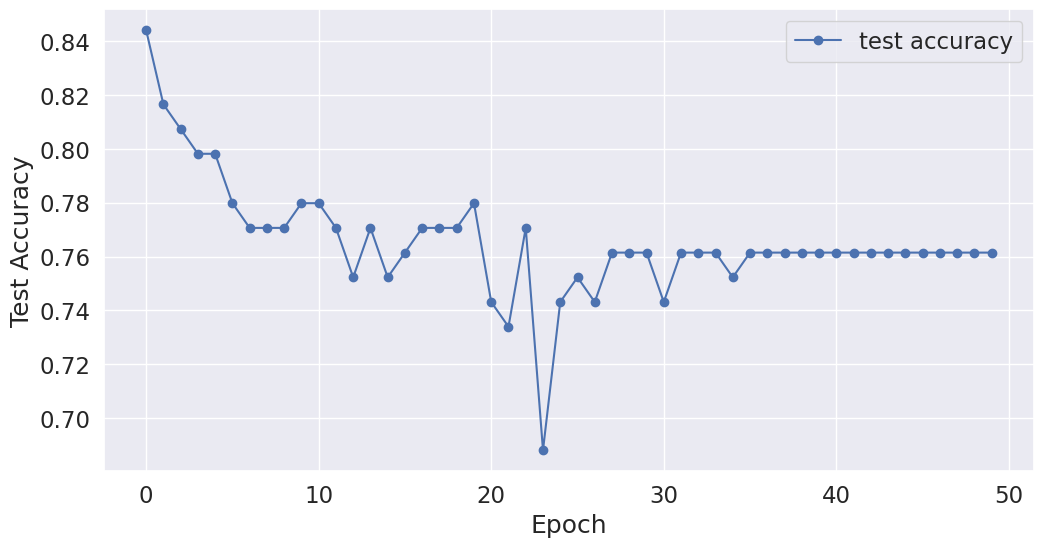

In [24]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [25]:
def acc():
    accuracy_list = []
    for i in range(len(sentences)):
        tokenized_sentence = tokenizer.encode(sentences[i])
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-2]
        accuracy_list.append(accuracy_score(new_labels, labels[i]))

        print("\nPredict labels: ",new_labels)
        print("Actual labels: ",labels[i])
        for p in range(len(new_labels)):
            print(sentences[i][p], new_labels[p], labels[i][p])

        return statistics.mean(accuracy_list)

In [26]:
acc()
sentences[0]

130

Predict labels:  ['0', '0', '0', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 

['The',
 'influence',
 'of',
 'γ',
 'radiation',
 'on',
 'the',
 'physical',
 'characteristics',
 'and',
 'sorption',
 'properties',
 'for',
 'Am',
 'of',
 'the',
 'solid',
 'extractant',
 'AXIONIT',
 'MND',
 '40T',
 'TVEX',
 'synthesized',
 'by',
 'Axion',
 'Rare',
 'and',
 'Noble',
 'Metals',
 'JSC',
 'Perm',
 'was',
 'studied',
 'With',
 'an',
 'increase',
 'of',
 'the',
 'absorbed',
 'dose',
 'of',
 'γ',
 'radiation',
 'the',
 'granulometric',
 'composition',
 'bulk',
 'density',
 'and',
 'specific',
 'volume',
 'of',
 'TVEX',
 'change',
 'insignificantly',
 'The',
 'IR',
 'spectra',
 'of',
 'TVEX',
 'demonstrate',
 'significant',
 'radiation',
 'degradation',
 'at',
 'an',
 'absorbed',
 'radiation',
 'dose',
 'from',
 '1',
 '4',
 'to',
 '2',
 '5',
 'MGy',
 'TVEX',
 'is',
 'an',
 'effective',
 'Am',
 'sorbent',
 'when',
 'irradiated',
 'to',
 'an',
 'absorbed',
 'γ',
 'radiation',
 'dose',
 'of',
 'no',
 'more',
 'than',
 '0',
 '6',
 'MGy',
 'At',
 'an',
 'irradiation',
 'dose',
 '

In [27]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

#parse sentences, currently separating by space
sentences = []
for i in range(0, len(info)):
    sentences.append(info[i]['text'].split())


#

labeled_sentences = []
labels = []
for i in range(0, len(sentences)):
    labels_temp =[]
    labeled_sentences_temp=[]
    index = 0
    entities = 0
    for j in range(0, len(sentences[i])):
        if len(info[i]['annotations']) ==0:
            labels_temp = [data_tags[0] for i in range(len(sentences[i]))]
           
       
        elif index == info[i]['annotations'][entities]['start_offset']:
            labeled_sentences_temp.append([sentences[i][j],data_tags[2*info[i]['annotations'][entities]['label']-1]])
            labels_temp.append(data_tags[2 * info[i]['annotations'][entities]['label']-1])
            
        elif index >= info[i]['annotations'][entities]['start_offset'] and index <= info[i]['annotations'][entities]['end_offset']:
            if labels_temp[j-1]==data_tags[0]:
                labeled_sentences_temp.append([sentences[i][j],data_tags[2*info[i]['annotations'][entities]['label']-1]])
                labels_temp.append(data_tags[2 * info[i]['annotations'][entities]['label']-1])
            else:
                labeled_sentences_temp.append([sentences[i][j],data_tags[(2 * info[i]['annotations'][entities]['label'] )]])
                labels_temp.append(data_tags[(2 * info[i]['annotations'][entities]['label'] ) ])
            
        elif index > info[i]['annotations'][entities]['end_offset']:
            if index + 1 == info[i]['annotations'][entities]['start_offset']:
                labeled_sentences_temp.append([sentences[i][j],data_tags[2*info[i]['annotations'][entities]['label']-1]])
                labels_temp.append(data_tags[2 * info[i]['annotations'][entities]['label']-1])
            else: 
                entities+=1
                labeled_sentences_temp.append([sentences[i][j], data_tags[0]])
                labels_temp.append(data_tags[0])
                if entities>=len(info[i]['annotations']):
                    entities = entities -1
        else:
            labeled_sentences_temp.append([sentences[i][j], data_tags[0]])
            labels_temp.append(data_tags[0])
            
        index += (len(sentences[i][j])+1)
    
    labeled_sentences.append(labeled_sentences_temp)
    labels.append(labels_temp)


        
for i in range(0, len(labeled_sentences)):
    print()
    print(sentences[i])
    print(labeled_sentences[i])
    print(labels[i])
    print()


['The', 'influence', 'of', 'γ-radiation', 'on', 'the', 'physical', 'characteristics', 'and', 'sorption', 'properties', 'for', 'Am', 'of', 'the', 'solid', 'extractant', 'AXIONIT', 'MND', '40T', '(TVEX)', 'synthesized', 'by', 'Axion-Rare', 'and', 'Noble', 'Metals', 'JSC', '(Perm)', 'was', 'studied.', 'With', 'an', 'increase', 'of', 'the', 'absorbed', 'dose', 'of', 'γ-radiation,', 'the', 'granulometric', 'composition,', 'bulk', 'density,', 'and', 'specific', 'volume', 'of', 'TVEX', 'change', 'insignificantly.', 'The', 'IR', 'spectra', 'of', 'TVEX', 'demonstrate', 'significant', 'radiation', 'degradation', 'at', 'an', 'absorbed', 'radiation', 'dose', 'from', '1.4', 'to', '2.5', 'MGy.', 'TVEX', 'is', 'an', 'effective', 'Am', 'sorbent', 'when', 'irradiated', 'to', 'an', 'absorbed', 'γ-radiation', 'dose', 'of', 'no', 'more', 'than', '0.6', 'MGy.', 'At', 'an', 'irradiation', 'dose', 'of', '2.5', 'MGy', 'sorption', 'capacity', 'is', 'significantly', 'reduced.']
[['The', '0'], ['influence', '0'